# Why Causal Analysis is Needed
In this example we will perform a quick causal analysis to estimate the _causal effect_ of smoking cessation on weight gain over a period of a decade.   
We will compare these results to the _observed effect_, arising from simple descriptive statistics.  
We'll then dig deeper into the data and see why such discrepancies arise.

## The Data
We will use data from an NHEFS observational study. 
The NHANS (National Health and Nutrition Examionation Survey) Epidemiologic Followup Study (NHEFS) is a national longitudinal study that was jointly initiated by the American National Center for Health Statistics and the American National Institute on Aging. 
The study was designed to follow up on smokers, some of whom quit smoking, and record their weight (among other measurements) for a period of 11 years: from 1971 to 1982.  
More information about the data can be found in the [NHEFS Notebook](/notebooks/nhefs.ipynb)

In [1]:
from causallib.datasets import load_nhefs

data = load_nhefs()
data.X.join(data.a).join(data.y).head()

,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2,qsmk,wt82_71
0,42,1,0,30,29,79.04,0,0,0,0,0,0,0,1,1764,6247.3216,900,841,0,-10.093960
1,36,0,0,20,24,58.63,0,0,1,0,0,0,0,0,1296,3437.4769,400,576,0,2.604970
2,56,1,1,20,26,56.81,0,0,1,0,0,0,0,1,3136,3227.3761,400,676,0,9.414486
3,68,1,0,3,53,59.42,1,0,0,0,0,0,0,1,4624,3530.7364,9,2809,0,4.990117
4,40,0,0,20,19,87.09,1,0,1,0,0,0,1,0,1600,7584.6681,400,361,0,4.989251


The data is already divided into three components: 
 * `X`: the confounders needed to be controlled for:
   * Demographics: such as `age`, `race`, `sex` and `education` level (how many years of schools).
   * Smoking habits: how many years an individual has been smoking (`smokeyrs`) and how many cigarettes per day (`smokeintensity`).
   * Well-being habits: how much active a participant is daily (`active`) and how much exercise they do in recreation (`exercise`).
   * Weight at the start of the study (`wt71`).
 * `a`: the treatment assignment - whether an individual had quit smoking or not.
 * `y`: the outcome - how much weight the individual gained during the follow up period of a decade.

## Estimating Causal Effect
### The Causal Model
For this demosntation, we will follow the most simple and well known causal model: _Inverse Probability of Treatment Weighting_ (also known as IPTW or IPW).  
This model requires estimating the propensity of each participant to stop smoking based on their individual features.   
Modeling this $\Pr[A=1|X]$ requires a machine learning model.  
`causallib` allows users to plug in any arbitrary ML model they want. 
For the sake of simplicity, we will use a logistic regression model.

In [2]:
from causallib.estimation import IPW
from sklearn.linear_model import LogisticRegression

learner = LogisticRegression(penalty='none',  # No regularization, new in scikit-learn 0.21.*
                             solver='lbfgs',
                             max_iter=500)    # Increased to achieve convergence with 'lbfgs' solver
ipw = IPW(learner)

### Applying Causal Analysis
Once we defined the causal model, we can move on to calculate the potential outcomes and the effect

In [3]:
ipw.fit(data.X, data.a)
potential_outcomes = ipw.estimate_population_outcome(data.X, data.a, data.y)
causal_effect = potential_outcomes[1] - potential_outcomes[0]
causal_effect

3.518555013088421

Our causal analysis concluded that, on average, smoking cessation contributed 3.5 kg (7.7 lbs) to the weight gain of people over a period of a decade.  
Put differently, had **all** the participants stoped smoking, they would have weighed 3.5 kg more than if **all** participants had continued to smoke.

## Estimating Observed Effect
Say you are tasked with estimating how much smoking cessation contributes to weight gain but you are not familiar with causal analysis.  
On the face of it, it might sound simple. You simply measure the weight-gain in the people who continued smoking, you measure the weight gain in people who quit, and compare the two quantities to see how much the people who quit gained more (or less) than the people who persisted.  
Basically you measure $\mathbb{E}[Y|A=1] - \mathbb{E}[Y|A=0]$

In [4]:
observed_outcomes = data.y.groupby(data.a).mean()
observed_effect = observed_outcomes[1] - observed_outcomes[0]
observed_effect

2.540581454955886

So if you were to avoid causal analysis, you would estimate that smoking cessation contributes only 2.5 kg (5.5 lbs) to the weight gain, as opposed to the 3.5 kg we calculated above. This is an under-estimation of close to 30 (!) percent.  
What can cause such a discrepancy between the descriptive-statistics calculation and the causal-based estimation?

## Analysis of the difference between causal and observed effect
We saw that the observed difference due to smoking cessation is 2.5 kg, while the causal inference analysis suggested it is closer to 3.5.  
Causal analysis, in its essence, tries to balance between the treatment and control groups before calculating the difference.  
Weight gain can be caused by many factors. 
For example, males tend to be larger than females on average, and they gain more weight on average. What if most of the people who quit smoking were female? That would bring down the observed effect.
Our observed analysis didn't account for the different distributions of such features between the treatment groups, and therefore the observed effect is _confounded_ and most likely "contaminated" with _spuriuous correlations_. 
Only when controlling for such correlations and eliminating their effect, we can claim that the differences in weight gain are truly only due to the status of smoking.

What the observed difference indicates is only that people who **chose** to quit smoking were observed to gain 2.5 Kg more than people who **chose** not to quit smoking. 

To get a clue of how the distribution differ between the treated and the controls, we can calculate the difference in means between groups for each variables. 
We visualize these differences in a plot called Love plot (named after Dr. Thomas Love).

In [5]:
from causallib.evaluation import PropensityEvaluator

evaluator = PropensityEvaluator(ipw)
evaluations = evaluator.evaluate_simple(data.X, data.a, data.y, 
                                        plots=["covariate_balance_love"],
                                        metrics_to_evaluate={})

fig = evaluations.plots["covariate_balance_love"].get_figure()
fig.set_size_inches(6, 6);  # set a more compact size than default

The orange triangles show the differences in averages between for each covariates _before_ applying balancing.  
We see that `age` differs the most between the treatment groups, and we suspect it might be causing the discrepancy in results between the descriptive statistics and the causal analysis.

To further investigate this, let's look at the weight-gain as a function of the age:

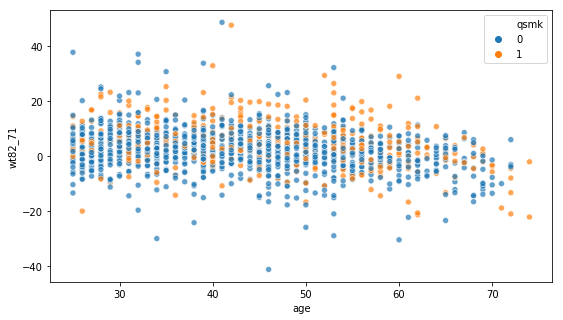

In [6]:
%matplotlib inline
import seaborn as sns

ax = sns.scatterplot(data.X["age"], data.y, hue=data.a, alpha=0.7)
ax.get_figure().set_size_inches(9, 5);

We observe that for older age people the weight-gain decreases to the point that it is more frequently negative than positive at very high age.

Let's break down the observed difference by age groups of 5 years each:

In [7]:
import pandas as pd

step_size = 5
age_groups = range(data.X["age"].min(), 
                   data.X["age"].max() + step_size, 
                   step_size)
print(list(age_groups))
age_grouped = pd.cut(data.X["age"], bins=age_groups, include_lowest=True)
age_grouped.head()

[25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]


0    (40.0, 45.0]
1    (35.0, 40.0]
2    (55.0, 60.0]
3    (65.0, 70.0]
4    (35.0, 40.0]
Name: age, dtype: category
Categories (10, interval[float64]): [(24.999, 30.0] < (30.0, 35.0] < (35.0, 40.0] < (40.0, 45.0] ... (55.0, 60.0] < (60.0, 65.0] < (65.0, 70.0] < (70.0, 75.0]]

Now we examine how the weight gain differ in each age-group:

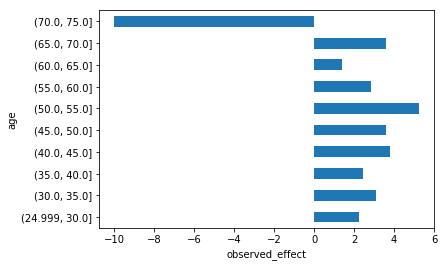

In [8]:
observed_diff_by_age = data.y.groupby([data.a, age_grouped]).mean()
observed_diff_by_age = observed_diff_by_age.xs(1) - observed_diff_by_age.xs(0)
observed_diff_by_age = observed_diff_by_age.rename("observed_effect")
ax = observed_diff_by_age.plot(kind="barh")
ax.set_xlabel("observed_effect");

We see here two interseting trends:
 * The oldest age group has an observed effect much lower than the others.
 * The people between ages 40-55 have larger observed difference than the average 2.5 kg.
It means when we do a simple average across all the treated and controls, we are mixing people with different observed effects:
$$
\mathbb{E}\left[Y|A=1,\text{Age}\gt70\right] - \mathbb{E}\left[Y|A=0,\text{Age}\gt70\right] \ll 
\mathbb{E}\left[Y|A=1,\text{Age}\in[40,55]\right] - \mathbb{E}\left[Y|A=0,\text{Age}\in[40,55]\right]
$$ 

This certainly has to be adjusted for. But how much? the overall effect will depend in the number of people in each age group:

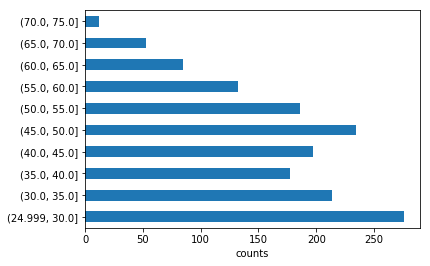

In [9]:
age_frequency = age_grouped.value_counts(sort=False)
age_frequency.rename("counts", inplace=True)
ax = age_frequency.plot(kind="barh")
ax.set_xlabel("counts");

In [10]:
by_age = observed_diff_by_age.to_frame().join(age_frequency)
by_age

,observed_effect,counts
age,,
"(24.999, 30.0]",2.263298,276
"(30.0, 35.0]",3.100541,214
"(35.0, 40.0]",2.433750,177
"(40.0, 45.0]",3.801950,197
"(45.0, 50.0]",3.603730,234
"(50.0, 55.0]",5.238368,186
"(55.0, 60.0]",2.871668,132
"(60.0, 65.0]",1.402340,85
"(65.0, 70.0]",3.602345,53


In fact, for the largest groups, ages 40 to 55, the observed effect is larger than the overall average observed effect (2.5kg).  
This is somewhat similar to [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox): 
How come combining groups with a large effect results in a small effect?  

To check this, we'll dig even deeper into the distribution of treated vs. control in each of these age groups:

In [11]:
tx_distribution_by_age = data.a.groupby(age_grouped).value_counts()
tx_distribution_by_age = tx_distribution_by_age.unstack("qsmk")
tx_distribution_by_age["propensity"] = tx_distribution_by_age[1] / tx_distribution_by_age.sum(axis="columns")

by_age = by_age.join(tx_distribution_by_age)
by_age

,observed_effect,counts,0,1,propensity
age,,,,,
"(24.999, 30.0]",2.263298,276,228,48,0.173913
"(30.0, 35.0]",3.100541,214,160,54,0.252336
"(35.0, 40.0]",2.433750,177,136,41,0.231638
"(40.0, 45.0]",3.801950,197,146,51,0.258883
"(45.0, 50.0]",3.603730,234,181,53,0.226496
"(50.0, 55.0]",5.238368,186,133,53,0.284946
"(55.0, 60.0]",2.871668,132,81,51,0.386364
"(60.0, 65.0]",1.402340,85,55,30,0.352941
"(65.0, 70.0]",3.602345,53,38,15,0.283019


We see that each age group has different proportions between the treated and control, 
meaning, _individuals in each treatment group have different propensity to quit smoking_.

We can go on and visualize the observed effect as a function of the propensity of each age group (blue dots), compared to the overall average (green line) and the effect derived from the causal analysis (orange line):

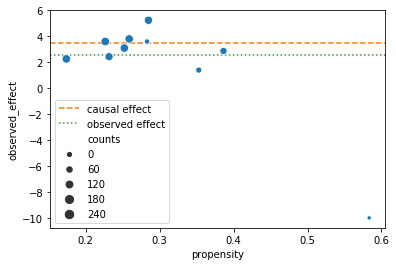

In [12]:
ax = sns.scatterplot(x="propensity", y="observed_effect", data=by_age.reset_index(),
                     size="counts", size_norm=(20, 200))
ax.axhline(y=causal_effect, linestyle="--", color="C1", label="causal effect", zorder=0)
ax.axhline(y=observed_effect, linestyle=":", color="C2", label="observed effect", zorder=0)
ax.legend();

It can be seen that the ratios of those who quit smoking is smaller (small propensity) in the groups for which the effect is large (the top left of the plot). The groups with small effect contribute disproportionately to the observed effect.
The overall observed effect is therefore smaller than what would have been observed if the ratios were the same across all groups. 
In fact, it would be closer to the 3.5 value that is predicted by the causal analysis.

More generally, both the effect size and the prevalence of treatment changes between age groups, and age is therefore a confounder of the effect. 
Therefore, the overall population effect can only be calculated by weighting the observed group-differences by the size of each age group.  
So if we were to average the observed effect and factoring in the size of each age group we would get:

In [13]:
import numpy as np

np.average(by_age["observed_effect"], weights=by_age["counts"])

3.1002018883702958

Observed effect of 3.1 is closer to the causal effect of 3.5, than to the simple observed effect of 2.5 we originally got.  
What we did was to take the already averaged-within-each-age-group effect and average it once more using the sizes of each group.  
This is equivalent to providing each individual with a propensity value based only on their age group, and then applying an inverse-probability-weighting scheme to obtain a slightly-more corrected effect.  
Let's do IPW by hand:
#### Building an age-based IPW model by hand

In [14]:
# Give each individual their propensity according their age group:
individual_age_weights = age_grouped.map(by_age["propensity"])

# Give each individual the pobability to be in their original treatment group,
# i.e. the treated get their propensity (=probability to be treated) 
#      and the control get 1 minus that propensity (=probability to by untreated)
individual_age_weights = (data.a * individual_age_weights) + ((1-data.a) * (1-individual_age_weights))

# We then inverse these propensity:
individual_age_weights = 1 / individual_age_weights

# We use the inversed propensities to create a weighted outcome:
weighted_outcome = individual_age_weights * data.y

# Finaly, we take the weighted average of the weighted outcome in each treatment group:
weighted_outcome = weighted_outcome.groupby(data.a).sum() / individual_age_weights.groupby(data.a).sum()

# And we can 
weighted_outcome[1] - weighted_outcome[0]

3.100201888370302

Indeed we got the same effect as the weighted-average-of-averages above.

However, remember we had only 10 unique propensity values, because we arbitrarily binned the age variable into 10 age groups.  
Meanwhile, using a machine learning model allows us to model the propensity using `age` as a continuous variable.  
Let's examine what happens when using the age continuously, by building an IPW model that uses `age` as its sole feature when modeling propensity to treat.

In [15]:
learner = LogisticRegression(penalty='none', solver='lbfgs', max_iter=500)
ipw = IPW(learner)
ipw.fit(data.X[["age"]], data.a)
outcomes = ipw.estimate_population_outcome(data.X[["age"]], data.a, data.y)
outcomes[1] - outcomes[0]

3.098787136071221

Indeed we got an almost identical effect, correcting only for age in our IPW model.  
We can only assume that when correcting for more variables and eliminating more spuriuous correlations in the process, we will get to the causal effect of 3.5 kg.

### Summary
1. We saw that there is a discrepancy between the "effect" using simple descriptive statistics, and the causal effect resulting from a causal analysis.
2. The discrepancy originated from the groups (quitting or not quitting smoking) having different distributions of charachteristics, and thus, are not comparable.
3. We discovered that participants' age had the largest distributional shift among the treatment groups and focused on it.
4. We saw that the observed effect differed across different age groups, and that different age groups had different number of people, suggesting a simple average mixes different effects indifferently. 
5. We demonstrated that when accounting for the number of participants in each age group, the "effect" shifted from the original observed-effect towards the causal-effect.
7. We saw we get similar result when building a causal model that controls only for age (and not for all confounders).